<a href="https://colab.research.google.com/github/Joy439/skills-introduction-to-github/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import optim, device
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


import csv
import os
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [ ]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record,title=''):
    total_step = len(loss_record['train'])
    x1 = range(total_step)
    x2 = x1[::len(loss_record['train'])//len(loss_record['dev'])]
    figure(figsize=(6,4))
    plt.plot(x1,loss_record['train'],label='train',color='r')
    plt.plot(x2,loss_record['dev'],label='dev',color='b')
    plt.ylim(0.0,5.)
    plt.xlabel('Train steps')
    plt.ylabel('MSE Loss')
    plt.title('Learning Curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_pred(dv_set,model,device,lim=35.,preds=None,targets=None):
    if preds is None or targets is None:
        model.eval()
        preds, targets = [],[]
        for x,y in dv_set:
            x,y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds,dim=0).numpy()
        targets = torch.cat(targets,dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [ ]:


tr_path = '/content/covid.train.csv'
tt_path = '/content/covid.test.csv'

# Dataset
class COVID19Dataset(Dataset):
    '''
    Dataset:
      read .csv file -> path
      extract features
      split covid.train.csv into train/dev sets
      normalize features
    '''
    def __init__(self,path,mode='train',target_only=False):
        self.mode = mode
        self.path = path
        # read data into numpy arrays
        with open(self.path,'r') as f:
            data = list(csv.reader(f))  #csv.reader()直接返回的是读取器，list()转化为列表格式
            data = np.array(data[1:])[:,1:].astype(float)

        if not target_only:  # 选择是否要简化特征维度（可选
            feats = list(range(93))
        else:
            # 40 states & 2 tested_positive_features
            # 只用前40列状态特征+2个特征（索引57， 75
            feats = list(range(40))+[57,75]

        if mode == 'test':
            # testing data
            # data：893 * 93
            data = data[:,feats]   # 只选取前93列数据，不放入标签
            self.data = torch.FloatTensor(data)
        else:
            # training data
            # data: 2700 * 94
            target = data[:,-1]
            data = data[:, feats]

            # 将训练数据分为 训练集 & 评估集
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # 对40列及以后的部分标准化（消除量级的影响，加速模型收敛
        self.data[:,40:] =\
            (self.data[:,40:]-self.data[:,40:].mean(dim=0,keepdim=True))\
             /self.data[:,40:].std(dim=0,keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found,'
              'each dim = {})'.format(mode,len(self.data),self.dim))


    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        if self.mode in['train','dev']:
            return self.data[idx],self.target[idx]
        else:
            return self.data[idx]

# DataLoader
def prep_dataloader(path,mode,batch_size,target_only=False):
    dataset = COVID19Dataset(path,mode=mode,target_only=target_only)
    dataloader = DataLoader(
        dataset,batch_size,
        shuffle=(mode == 'train')
    )
    return dataloader

# network
class NeuralNet(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        x = self.net(x)
        return x.squeeze(1)
        # 网络输出结果形状为(batch_size，1),squeeze(1):dim=1的维度如果是1则省去，不是1则不影响

    def cal_loss(self,pred,target):
        return self.criterion(pred,target)


# Training
def train(tr_set,dv_set,model,config,device):
    epochs = config['n_epochs'] # 训练轮次

    optimizer = torch.optim.SGD(model.parameters(),lr=config['lr'],momentum=config['momentum'] )
    loss_record = {'train':[],'dev':[]}
    min_mse = 1000.
    early_stop_cnt = 0
    for epoch in range(epochs):
        # 训练时要设置成train（），每轮过一遍就要在验证集检验一遍
        model.train()
        for x,y in tr_set:
            x,y = x.to(device), y.to(device)
            pred = model(x)
            mse_loss = model.cal_loss(pred,y)

            optimizer.zero_grad()
            mse_loss.backward()
            optimizer.step()

            loss_record['train'].append(mse_loss.detach().cpu().item())
        # 验证
        dev_mse = dev(dv_set,model,device)
        loss_record['dev'].append(dev_mse)
        if dev_mse < min_mse:  # 如果loss达到期望就早停，保存参数，和loss等数据
            min_mse = dev_mse
            print('Saving model (epoch={},loss={:.4f}'.format(epoch+1,min_mse))
            torch.save(model.state_dict(),config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        if early_stop_cnt > config['early_stop']:
            break

    print('Finished training after {} epochs'.format(epochs))
    return min_mse,loss_record


# Validation
def dev(dv_set,model,device):
    model.eval()
    total_loss = 0
    for x,y in dv_set:
        x,y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            mse_loss = model.cal_loss(pred,y)
        total_loss += mse_loss.detach().cpu().item()*len(x)
    total_loss = total_loss/len(dv_set.dataset)

    return total_loss

# Testing
def test(tt_set,model,device):
    model.eval()
    preds = []
    for x in tt_set:
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds,dim=0).numpy()
    return preds



In [ ]:

device = get_device()
os.makedirs('model',exist_ok=True)
target_only = False

config = {
    'n_epochs':3000,
    'batch_size':270,
    'lr':0.001,
    'momentum':0.9,
    'early_stop':200,
    'save_path':'model/model.path'
}


In [ ]:
tr_set = prep_dataloader(tr_path,'train',config['batch_size'],target_only=target_only)
dv_set = prep_dataloader(tr_path,'dev',config['batch_size'],target_only=target_only)
tt_set = prep_dataloader(tt_path,'test',config['batch_size'],target_only=target_only)

model = NeuralNet(tr_set.dataset.dim).to(device)

model_loss,model_loss_record = train(tr_set,dv_set,model,config,device)


Finished reading the train set of COVID19 Dataset (2430 samples found,each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found,each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found,each dim = 93)
Saving model (epoch=1,loss=78.8524
Saving model (epoch=2,loss=37.6170
Saving model (epoch=3,loss=26.1203
Saving model (epoch=4,loss=16.1862
Saving model (epoch=5,loss=9.7153
Saving model (epoch=6,loss=6.3701
Saving model (epoch=7,loss=5.1802
Saving model (epoch=8,loss=4.4255
Saving model (epoch=9,loss=3.8009
Saving model (epoch=10,loss=3.3691
Saving model (epoch=11,loss=3.0943
Saving model (epoch=12,loss=2.8176
Saving model (epoch=13,loss=2.6274
Saving model (epoch=14,loss=2.4542
Saving model (epoch=15,loss=2.3012
Saving model (epoch=16,loss=2.1766
Saving model (epoch=17,loss=2.0641
Saving model (epoch=18,loss=1.9399
Saving model (epoch=19,loss=1.8978
Saving model (epoch=20,loss=1.7950
Saving model (epoch=21,loss=1.7164
Saving model (epoch=

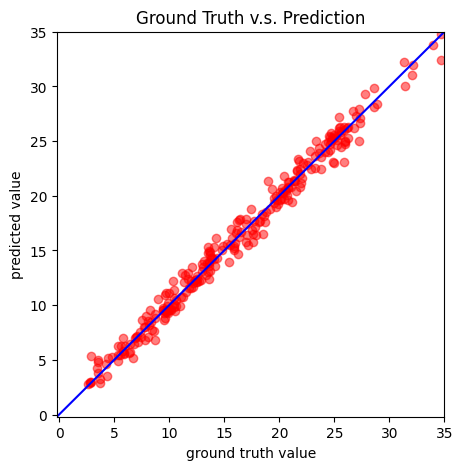

Saving results to pred.csv


In [ ]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device) # 重新定义模型结构
ckpt = torch.load(config['save_path'],map_location='cpu')
model.load_state_dict(ckpt) # 加载参数

plot_pred(dv_set,model,device)

def save_pred(preds,file):
    print('Saving results to {}'.format(file))
    with open(file,'w') as fp:
        writer = csv.writer(fp)
        writer.writerows(['id','tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i,p])
preds = test(tt_set,model,device)
save_pred(preds,'pred.csv')

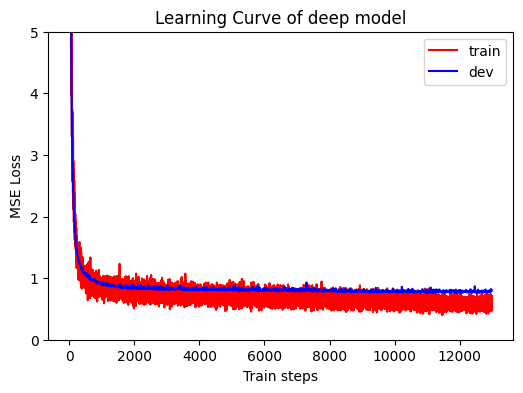

In [ ]:
plot_learning_curve(model_loss_record, title='deep model')
